In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [410]:
# Select GPU device
if torch.cuda.is_available():
    print("Cuda!")
    device   = 'cuda' 
else:
    print("Cpu :( ")
    device   = 'cpu'

Cpu :( 


In [427]:
# Load data
path     = '/mnt/c/Users/han/Downloads/BEACO2N-CO2/data_v1/'
X_train  = torch.Tensor(np.load(path + 'X_train.npy', allow_pickle=True))
X_test   = torch.Tensor(np.load(path + 'X_test.npy', allow_pickle=True))
X_val    = torch.Tensor(np.load(path + 'X_val.npy', allow_pickle=True))
y_train  = torch.Tensor(np.load(path + 'y_train.npy', allow_pickle=True))
y_test   = torch.Tensor(np.load(path + 'y_test.npy', allow_pickle=True))
y_val    = torch.Tensor(np.load(path + 'y_val.npy', allow_pickle=True))

In [428]:
class co2Dataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [429]:
class co2ValData(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [422]:
def create_model(n_layers, activation, combiners):
    
    if len(activation) != n_layers:
        act = [activation[0]]*(n_layers - 1)
        act.append(activation[-1])
    else:
        act = activations
    if len(combiners) != n_layers:
        combine = [combiners[0]]*(n_layers - 1)
        combine.append(combiners[-1])
    else:
        combine = combiners
        
    for layer in range(n_layers):
        if layer == 0:
            model = nn.Sequential(combine[layer])
            if act[layer]:
                model.add_module(name=str(2*layer+1), module=act[layer])
        else:
            model.add_module(name=str(2*layer),module=combine[layer])
            if act[layer]:
                model.add_module(name=str(2*layer+1), module=act[layer])
                
    return model

In [423]:
def make_model_train_step( model, loss_fn, optimizer):
    
    def model_step(X, y):
        model.train()
        # Forward Pass
        y_pred = model(X)

        # Compute loss
        loss  = loss_fn(y, y_pred)
        #print('epoch: ',epoch, ' loss: ', loss.item())
        # Perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step() 
        
        #Zero the gradients (so that gradients don't accumulate from epoch to epoch)
        optimizer.zero_grad()

        return loss.item()
    
    return model_step

In [424]:
def evaluate_model(model):
    model.eval()
    ypred = model(X_test)
    ypred = [a[0] for a in ypred]
    ypred = torch.Tensor(ypred)
    err = torch.mean((ypred-y_test)**2)
    print("Y_pred std: ", torch.std(ypred))
    print("Y_train std: ", torch.std(y_train))
    print("Y_train Mean: ",torch.mean(y_train))
    print("Y_predicted: ", ypred[1:10])
    print("Y_test: ", y_test[1:10])
    print("Error: ",err)
    return ypred

In [425]:
def reset_model(model):
    m = model
    for name, module in m.named_children():
        try:
            module.reset_parameters()
            print('resetting ', name)
        except: 
            print('not resetting', name, ' - no attribute "reset parameters"')

In [430]:
# Define Model Parameters    
nsize_in      = X_train.shape[1] 
nsize_out     = 1
nsize_hidden1 = int(X_train.shape[1]/4)
nsize_hidden2 = int(nsize_hidden1/4)
nsize_hidden3 = int(nsize_hidden2/4)
n_layers      = 4
activations   = [nn.Sigmoid(),
                 nn.Sigmoid(),#nn.ReLU(),
                 nn.Sigmoid(),#nn.ReLU(), 
                 None]
layer_combiners = [nn.Linear(nsize_in, nsize_hidden1),
                   nn.Linear(nsize_hidden1, nsize_hidden2),
                   nn.Linear(nsize_hidden2, nsize_hidden3),
                   nn.Linear(nsize_hidden3, nsize_out)]
learning_rate = 0.0005
momentum = 0
nesterov = False
n_epochs      = 50
# Put training and validation data into a pytorch Dataset, create a Dataloader (Used for batching the data)
train_data = co2Dataset(X_train,y_train)
train_loader = DataLoader(dataset=train_data, batch_size=200)

val_data = co2ValData(X_val,y_val)
val_loader = DataLoader(dataset=val_data, batch_size=200)


# Define model
model = create_model(n_layers, activations, layer_combiners)

# Define Loss function
loss_fn = nn.MSELoss(reduction='mean')

# Define Optimizer method
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=momentum, nesterov=nesterov)

# Create model step
model_step = make_model_train_step(model, loss_fn, optimizer)

losses = []
val_losses = []

# Train Model
for epoch in range(100):
    l = []
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = model_step(x_batch, y_batch)

        l.append(loss)
    print('epoch: ',epoch, ' loss: ', np.mean(l))
    losses.append(np.mean(l))
    
    with torch.no_grad():
        val_l = []
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_l.append(val_loss.item())
    val_losses.append(np.mean(val_l))


epoch:  0  loss:  154578.72278792135
epoch:  1  loss:  108500.53818469102
epoch:  2  loss:  76105.13671875
epoch:  3  loss:  53421.47116397472
epoch:  4  loss:  37538.034388167136
epoch:  5  loss:  26416.241880266854
epoch:  6  loss:  18628.615453827246
epoch:  7  loss:  13175.636137201545
epoch:  8  loss:  9357.388578607795
epoch:  9  loss:  6683.841061709972
epoch:  10  loss:  4811.836335257198
epoch:  11  loss:  3501.0614576018256


KeyboardInterrupt: 

In [418]:
reset_model(model)

resetting  0
not resetting 1  - no attribute "reset parameters"
resetting  2
not resetting 3  - no attribute "reset parameters"
resetting  4
not resetting 5  - no attribute "reset parameters"
resetting  6


Y_pred std:  tensor(9.4148e-05)
Y_train std:  tensor(20.9800)
Y_train Mean:  tensor(423.8772)
Y_predicted:  tensor([423.8896, 423.8896, 423.8896, 423.8896, 423.8897, 423.8896, 423.8897,
        423.8896, 423.8897])
Y_test:  tensor([410.1866, 414.9282, 431.8382, 422.6009, 414.9842, 413.7069, 414.5592,
        410.2948, 412.2081])
Error:  tensor(435.2107)


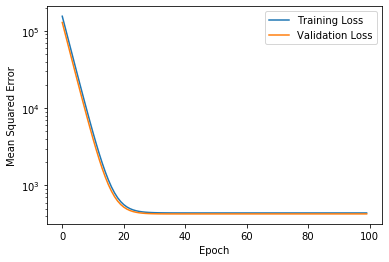

In [416]:
# Visualize data
ypred = evaluate_model(model)
ind = 0
vloss = [v for v in val_losses[ind:]]
a     = [a1 for a1 in losses[ind:]]
plt.figure()
plt.semilogy(range(len(a)), a, label="Training Loss")
plt.semilogy(range(len(vloss)), vloss , label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

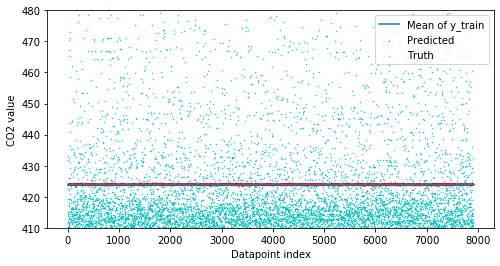

In [386]:
#  Scatter plot of predictions 
plt.figure(figsize=(8,4))
plt.scatter(np.arange(len(ypred)),ypred, s = .2, color='r', label='Predicted')
plt.scatter(np.arange(len(y_test)),y_test, s = .2, color='c', label='Truth')
plt.plot(np.arange(len(y_test)),torch.ones(len(y_test))*torch.mean(y_train), label='Mean of y_train' )
plt.ylim(top=480)
plt.ylim(bottom=410)
plt.xlabel('Datapoint index')
plt.ylabel('CO2 value')
plt.legend()
    